In [ ]:
#COMP 478/6771 - Image Processing --- Winter 2022
#Jupyter Notebook of final project
#Project title: Multi-class surface defect classification on 3D concrete printing structures using deep learning
#Students: Vasileios Sergis (ID: 40239274) Hua Wang (ID: )
import torch
import torch.nn as nn  
import torch.optim as optim 
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder 
import torchvision
import os
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import WeightedRandomSampler as WRS
import numpy as np
from torch.optim import Adam

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
    
        if self.transform:
            image = self.transform(image)

        return (image, y_label)

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

device: cuda


In [ ]:
# Hyperparameters
in_channel = 3
num_classes = 4
batch_size = 32

my_transforms= transforms.Compose([
    #transforms.ToPILImage(),
    transforms.Resize((224, 224)),  
    transforms.RandomRotation(degrees=45),  # Perhaps a random rotation from -45 to 45 degrees
    transforms.RandomHorizontalFlip(p=0.5),  # Flips the image horizontally with probability 0.5
    transforms.RandomVerticalFlip(p=0.05),  # Flips image vertically with probability 0.05
    transforms.RandomGrayscale(p=0.2),  # Converts to grayscale with probability 0.2
    transforms.ToTensor(),  # Finally converts PIL image to tensor so we can train w. pytorch
])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/My Drive/Colab Notebooks/c6771/dataset/'  # Google drive
dataset = ImageFolder(path, transform=my_transforms)
print(f'number of images: {len(dataset)}')
print(f'number of classes: {len(dataset.classes)}')

number of images: 2294
number of classes: 4


In [ ]:
339+1196+700+49

class_weights=[]

In [ ]:
# Dataset is actually a lot larger ~25k images, just took out 10 pictures
# to upload to Github. It's enough to understand the structure and scale
# if you got more images.
total=len(dataset) #339+1196+700+49+10
tr=int(np.floor(total*0.7))
te=int(total-tr)
train_set, test_set = torch.utils.data.random_split(dataset, [tr, te])

class_weights=[]
for root, subdir, files in sorted(os.walk(path)):
  if len(files)>0:
    print(len(files))
    class_weights.append(1/len(files))

sample_weights = [0]*len(train_set)

for idx, (data,label) in enumerate(train_set):
    class_weight=class_weights[label]
    sample_weights[idx]=class_weight
sampler=WRS(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, sampler=sampler)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)


348
49
1196
701


In [ ]:
print(class_weights)

[0.0028735632183908046, 0.02040816326530612, 0.0008361204013377926, 0.0014265335235378032]


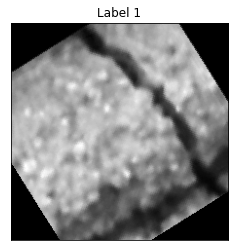

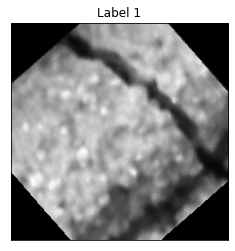

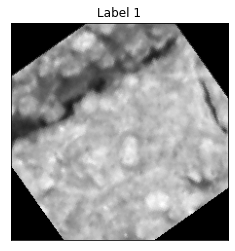

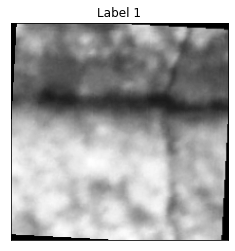

torch.Size([224, 224])


In [ ]:
example=iter(train_loader)
sample, label = example.next()
for i in range(len(sample)):
    plt.title('Label ' + str(label[i].item()))
    plt.imshow(sample[i][0], cmap='gray')
    plt.xticks([]),plt.yticks([])
    plt.show()
print(sample[1][0].shape)

In [ ]:
from tqdm import tqdm
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def train_model(model,train_loader,criterion,optimizer,learning_rate,num_epochs):

    # Train Network
    model.train()
    for epoch in tqdm(range(num_epochs)):
        losses = []

        for batch_idx, (data, targets) in enumerate(train_loader):
            # Get data to cuda if possible
            data = data.to(device=device)
            targets = targets.to(device=device)

            # forward
            scores = model(data)
            #if (batch_idx==0):
            #    print(scores,targets)
            loss = criterion(scores, targets)

            losses.append(loss.item())

            # backward
            optimizer.zero_grad()
            loss.backward()

            # gradient descent or adam step
            optimizer.step()

        print(f" Cost at epoch {epoch} is {sum(losses)/len(losses)}")

# Check accuracy on training to see how good our model is
def check_accuracy(loader, model, mode="Train"):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        pred_labels = []
        real_labels = []
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            real_labels += y.cpu()

            scores = model(x)
            _, predictions = scores.max(1)

            pred_labels += predictions.cpu()
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        cm = confusion_matrix(real_labels, pred_labels)
        class_names = [0,1,2,3]

        # Plot confusion matrix in a beautiful manner
        fig = plt.figure(figsize=(8, 7),dpi=80)
        ax= plt.subplot()
        sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
        # labels, title and ticks
        ax.set_xlabel('Predicted', fontsize=20)
        ax.xaxis.set_label_position('bottom')
        plt.xticks(rotation=90)
        ax.xaxis.set_ticklabels(class_names, fontsize = 10)
        ax.xaxis.tick_bottom()

        ax.set_ylabel('True', fontsize=20)
        ax.yaxis.set_ticklabels(class_names, fontsize = 10)
        plt.yticks(rotation=0)

        plt.title(mode+' Confusion Matrix', fontsize=20)

        plt.savefig(model.__class__.__name__+'_'+mode+'.png')
        plt.show()                  

        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
        )
    model.train()

In [ ]:
learning_rate = 1e-4
num_epochs = 15

# Model
googlenet = torchvision.models.googlenet(pretrained=True)

#change fc layer output dimension 
num_ftrs = googlenet.fc.in_features
googlenet.fc = nn.Linear(num_ftrs, num_classes)

googlenet.to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(googlenet.fc.parameters(), lr=learning_rate)


# Train Network
train_model(googlenet, train_loader, criterion, optimizer, learning_rate, num_epochs)

  7%|▋         | 1/15 [00:08<02:00,  8.57s/it]

 Cost at epoch 0 is 1.3621020200205785


 13%|█▎        | 2/15 [00:17<01:51,  8.58s/it]

 Cost at epoch 1 is 1.3335516569661159


 20%|██        | 3/15 [00:25<01:42,  8.58s/it]

 Cost at epoch 2 is 1.285079839182835


 27%|██▋       | 4/15 [00:34<01:34,  8.59s/it]

 Cost at epoch 3 is 1.243404133647096


 33%|███▎      | 5/15 [00:42<01:25,  8.56s/it]

 Cost at epoch 4 is 1.2255010978848326


 40%|████      | 6/15 [00:51<01:16,  8.54s/it]

 Cost at epoch 5 is 1.187779751478457


 47%|████▋     | 7/15 [00:59<01:08,  8.53s/it]

 Cost at epoch 6 is 1.1634810648712457


 53%|█████▎    | 8/15 [01:08<01:00,  8.57s/it]

 Cost at epoch 7 is 1.1406455717834771


 60%|██████    | 9/15 [01:18<00:54,  9.09s/it]

 Cost at epoch 8 is 1.1377296284133314


 67%|██████▋   | 10/15 [01:27<00:44,  8.94s/it]

 Cost at epoch 9 is 1.0937000057276558


 73%|███████▎  | 11/15 [01:35<00:35,  8.83s/it]

 Cost at epoch 10 is 1.0877221775989907


 80%|████████  | 12/15 [01:44<00:26,  8.73s/it]

 Cost at epoch 11 is 1.0878256115258909


 87%|████████▋ | 13/15 [01:52<00:17,  8.67s/it]

 Cost at epoch 12 is 1.0665501566494213


 93%|█████████▎| 14/15 [02:01<00:08,  8.63s/it]

 Cost at epoch 13 is 1.0502478106349122


100%|██████████| 15/15 [02:10<00:00,  8.67s/it]

 Cost at epoch 14 is 1.0417567152603


Checking accuracy on Training Set


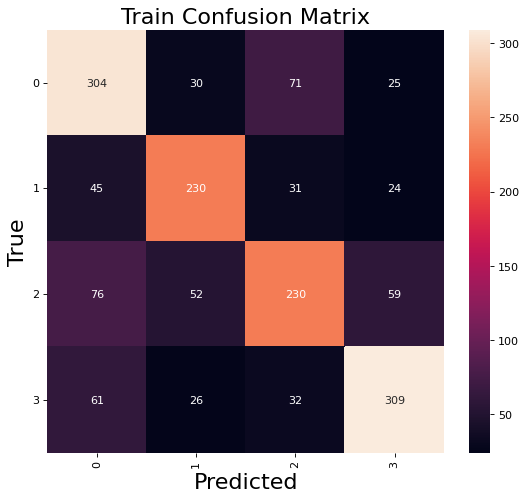

Got 1073 / 1605 with accuracy 66.85
Checking accuracy on Test Set


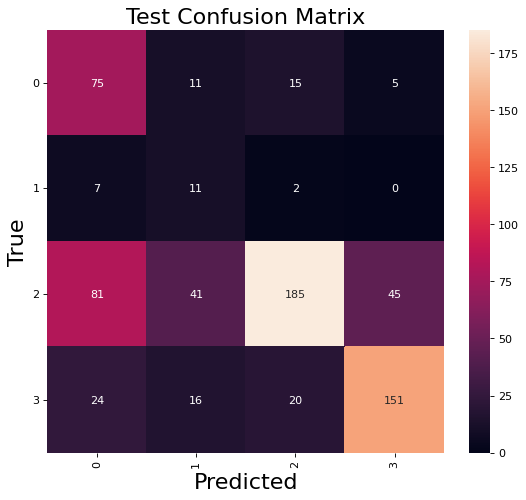

Got 422 / 689 with accuracy 61.25


In [ ]:
print("Checking accuracy on Training Set")
check_accuracy(train_loader, googlenet)

print("Checking accuracy on Test Set")
check_accuracy(test_loader, googlenet,'Test')

In [ ]:
learning_rate = 1e-4
num_epochs = 15

# Model
googlenet = torchvision.models.googlenet(pretrained=True)

#change fc layer output dimension 
num_ftrs = googlenet.fc.in_features
googlenet.fc = nn.Linear(num_ftrs, num_classes)

googlenet.to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(googlenet.parameters(), lr=learning_rate)


# Train Network
train_model(googlenet, train_loader, criterion, optimizer, learning_rate, num_epochs)

  7%|▋         | 1/15 [00:10<02:31, 10.81s/it]

 Cost at epoch 0 is 1.0119108920003854


 13%|█▎        | 2/15 [00:21<02:20, 10.78s/it]

 Cost at epoch 1 is 0.4633253056044672


 20%|██        | 3/15 [00:32<02:09, 10.75s/it]

 Cost at epoch 2 is 0.2937018471021278


 27%|██▋       | 4/15 [00:42<01:58, 10.73s/it]

 Cost at epoch 3 is 0.2548246735743448


 33%|███▎      | 5/15 [00:53<01:47, 10.76s/it]

 Cost at epoch 4 is 0.20321535253349474


 40%|████      | 6/15 [01:04<01:36, 10.75s/it]

 Cost at epoch 5 is 0.20680317377635077


 47%|████▋     | 7/15 [01:15<01:26, 10.82s/it]

 Cost at epoch 6 is 0.16014293544724875


 53%|█████▎    | 8/15 [01:26<01:15, 10.84s/it]

 Cost at epoch 7 is 0.17436799730229027


 60%|██████    | 9/15 [01:37<01:04, 10.81s/it]

 Cost at epoch 8 is 0.16129464919076247


 67%|██████▋   | 10/15 [01:47<00:53, 10.79s/it]

 Cost at epoch 9 is 0.1252409963338983


 73%|███████▎  | 11/15 [01:58<00:43, 10.80s/it]

 Cost at epoch 10 is 0.12150748154404116


 80%|████████  | 12/15 [02:09<00:32, 10.80s/it]

 Cost at epoch 11 is 0.1440587408986746


 87%|████████▋ | 13/15 [02:20<00:21, 10.79s/it]

 Cost at epoch 12 is 0.11670379554305006


 93%|█████████▎| 14/15 [02:31<00:10, 10.79s/it]

 Cost at epoch 13 is 0.11749161359872304


100%|██████████| 15/15 [02:41<00:00, 10.78s/it]

 Cost at epoch 14 is 0.10226820889568213


Checking accuracy on Training Set


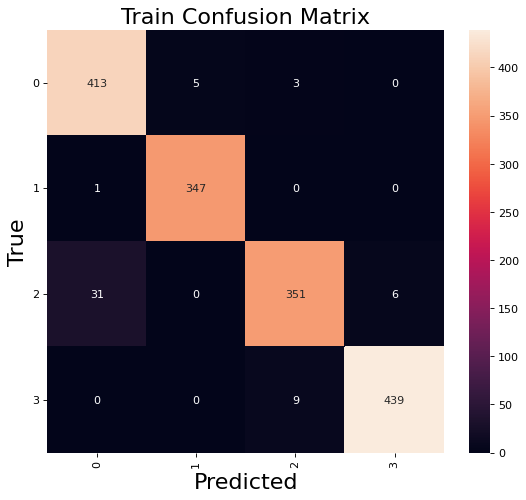

Got 1550 / 1605 with accuracy 96.57
Checking accuracy on Test Set


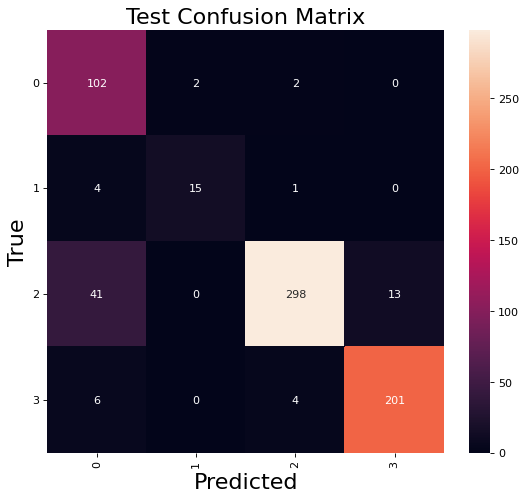

Got 616 / 689 with accuracy 89.40


In [ ]:
print("Checking accuracy on Training Set")
check_accuracy(train_loader, googlenet)

print("Checking accuracy on Test Set")
check_accuracy(test_loader, googlenet,'Test')

In [ ]:
learning_rate = 1e-4
num_epochs = 15

# Model
resnet18 = torchvision.models.resnet18(pretrained=True)


#change fc layer output dimension 
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, num_classes)

resnet18.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=learning_rate)

# Train Network
train_model(resnet18,train_loader,criterion,optimizer,learning_rate,num_epochs)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

  7%|▋         | 1/15 [00:08<01:55,  8.25s/it]

 Cost at epoch 0 is 0.7539646117126241


 13%|█▎        | 2/15 [00:16<01:50,  8.48s/it]

 Cost at epoch 1 is 0.3717199116945267


 20%|██        | 3/15 [00:25<01:43,  8.63s/it]

 Cost at epoch 2 is 0.254033854925165


 27%|██▋       | 4/15 [00:33<01:32,  8.39s/it]

 Cost at epoch 3 is 0.2091008329800531


 33%|███▎      | 5/15 [00:41<01:22,  8.27s/it]

 Cost at epoch 4 is 0.1668432400214906


 40%|████      | 6/15 [00:49<01:13,  8.19s/it]

 Cost at epoch 5 is 0.1703442568872489


 47%|████▋     | 7/15 [00:57<01:05,  8.14s/it]

 Cost at epoch 6 is 0.1948223106709181


 53%|█████▎    | 8/15 [01:05<00:56,  8.11s/it]

 Cost at epoch 7 is 0.1779041331553576


 60%|██████    | 9/15 [01:13<00:48,  8.09s/it]

 Cost at epoch 8 is 0.14842768296526343


 67%|██████▋   | 10/15 [01:21<00:40,  8.06s/it]

 Cost at epoch 9 is 0.11722524288822622


 73%|███████▎  | 11/15 [01:30<00:32,  8.08s/it]

 Cost at epoch 10 is 0.13487755430533604


 80%|████████  | 12/15 [01:38<00:24,  8.11s/it]

 Cost at epoch 11 is 0.14369049295783043


 87%|████████▋ | 13/15 [01:46<00:16,  8.12s/it]

 Cost at epoch 12 is 0.1267288448471649


 93%|█████████▎| 14/15 [01:54<00:08,  8.08s/it]

 Cost at epoch 13 is 0.17772243633939355


100%|██████████| 15/15 [02:02<00:00,  8.17s/it]

 Cost at epoch 14 is 0.1187223938531151


Checking accuracy on Training Set


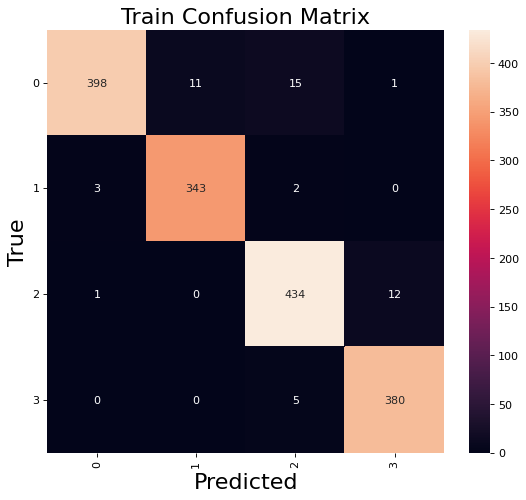

Got 1555 / 1605 with accuracy 96.88
Checking accuracy on Test Set


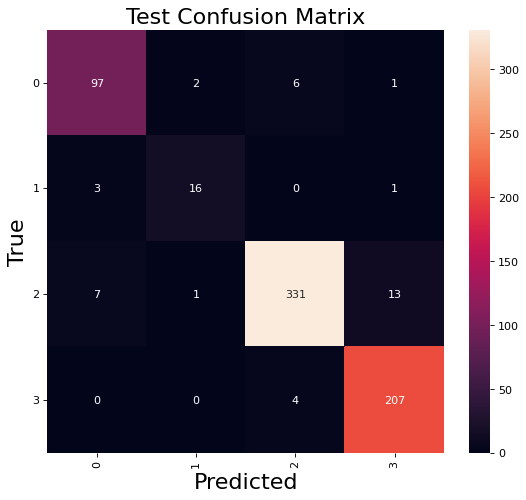

Got 651 / 689 with accuracy 94.48


In [ ]:
print("Checking accuracy on Training Set")
check_accuracy(train_loader, resnet18)

print("Checking accuracy on Test Set")
check_accuracy(test_loader, resnet18,'Test')

In [ ]:
learning_rate = 1e-4
num_epochs = 15

# Model
alexnet = torchvision.models.alexnet(pretrained=True)

#change fc layer output dimension 
num_ftrs = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(num_ftrs, num_classes)

alexnet.to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=learning_rate)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
# Train Network
train_model(alexnet,train_loader,criterion,optimizer,learning_rate,num_epochs)

  7%|▋         | 1/15 [00:07<01:43,  7.37s/it]

 Cost at epoch 0 is 1.2681233380355088


 13%|█▎        | 2/15 [00:14<01:35,  7.33s/it]

 Cost at epoch 1 is 0.9018337749967388


 20%|██        | 3/15 [00:21<01:27,  7.29s/it]

 Cost at epoch 2 is 0.6740923044728298


 27%|██▋       | 4/15 [00:29<01:20,  7.31s/it]

 Cost at epoch 3 is 0.5873431417287565


 33%|███▎      | 5/15 [00:36<01:13,  7.34s/it]

 Cost at epoch 4 is 0.5810359891723184


 40%|████      | 6/15 [00:43<01:05,  7.30s/it]

 Cost at epoch 5 is 0.40107156336307526


 47%|████▋     | 7/15 [00:51<00:58,  7.27s/it]

 Cost at epoch 6 is 0.359055742475332


 53%|█████▎    | 8/15 [00:58<00:50,  7.28s/it]

 Cost at epoch 7 is 0.30091746385191004


 60%|██████    | 9/15 [01:05<00:43,  7.31s/it]

 Cost at epoch 8 is 0.28013862640249965


 67%|██████▋   | 10/15 [01:13<00:36,  7.35s/it]

 Cost at epoch 9 is 0.2978304474084985


 73%|███████▎  | 11/15 [01:20<00:29,  7.33s/it]

 Cost at epoch 10 is 0.3293049893542832


 80%|████████  | 12/15 [01:27<00:21,  7.31s/it]

 Cost at epoch 11 is 0.23701380080013884


 87%|████████▋ | 13/15 [01:35<00:14,  7.32s/it]

 Cost at epoch 12 is 0.25340259513434243


 93%|█████████▎| 14/15 [01:42<00:07,  7.32s/it]

 Cost at epoch 13 is 0.2375842119548835


100%|██████████| 15/15 [01:49<00:00,  7.31s/it]

 Cost at epoch 14 is 0.21845860815807885


Checking accuracy on Training Set by using Alexnet


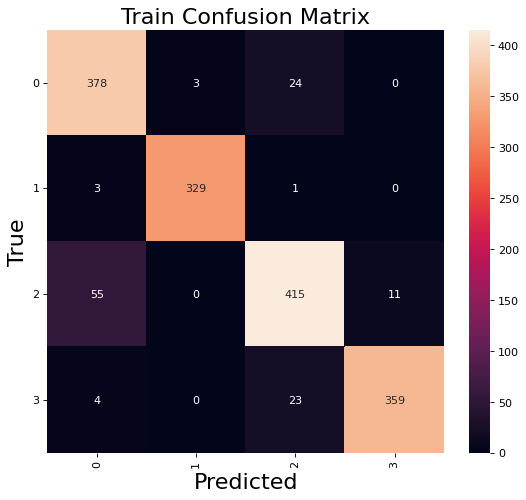

Got 1481 / 1605 with accuracy 92.27
Checking accuracy on Test Set by using Alexnet


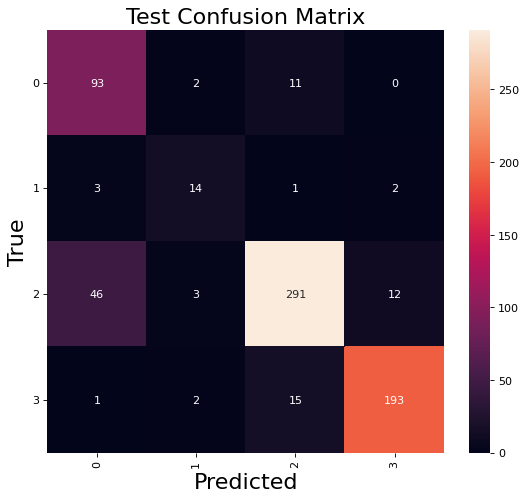

Got 591 / 689 with accuracy 85.78


In [ ]:
print("Checking accuracy on Training Set by using Alexnet")
check_accuracy(train_loader, alexnet)

print("Checking accuracy on Test Set by using Alexnet")
check_accuracy(test_loader, alexnet,'Test')

In [ ]:
learning_rate = 1e-4
num_epochs = 15

# Model
vgg16 = torchvision.models.vgg16(pretrained=True)

#change fc layer output dimension 
num_ftrs = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_ftrs, num_classes)

vgg16.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier[6].parameters(), lr=learning_rate)


In [ ]:
# Train Network
train_model(vgg16,train_loader,criterion,optimizer,learning_rate,num_epochs)

  7%|▋         | 1/15 [00:12<02:53, 12.36s/it]

 Cost at epoch 0 is 1.3907079135670382


 13%|█▎        | 2/15 [00:24<02:40, 12.35s/it]

 Cost at epoch 1 is 1.3293565114339192


 20%|██        | 3/15 [00:37<02:28, 12.41s/it]

 Cost at epoch 2 is 1.3053239209979188


 27%|██▋       | 4/15 [00:50<02:20, 12.77s/it]

 Cost at epoch 3 is 1.2564947511635574


 33%|███▎      | 5/15 [01:02<02:05, 12.60s/it]

 Cost at epoch 4 is 1.2354888530338513


 40%|████      | 6/15 [01:14<01:51, 12.38s/it]

 Cost at epoch 5 is 1.2116463605095358


 47%|████▋     | 7/15 [01:26<01:37, 12.24s/it]

 Cost at epoch 6 is 1.2249489204556334


 53%|█████▎    | 8/15 [01:38<01:25, 12.15s/it]

 Cost at epoch 7 is 1.218851178300147


 60%|██████    | 9/15 [01:50<01:12, 12.09s/it]

 Cost at epoch 8 is 1.1851963120348312


 67%|██████▋   | 10/15 [02:02<01:00, 12.04s/it]

 Cost at epoch 9 is 1.1950216830945481


 73%|███████▎  | 11/15 [02:14<00:48, 12.01s/it]

 Cost at epoch 10 is 1.1863021616842233


 80%|████████  | 12/15 [02:26<00:35, 11.99s/it]

 Cost at epoch 11 is 1.159642733779608


 87%|████████▋ | 13/15 [02:38<00:23, 11.98s/it]

 Cost at epoch 12 is 1.1669648803916632


 93%|█████████▎| 14/15 [02:51<00:12, 12.22s/it]

 Cost at epoch 13 is 1.1509977135003782


100%|██████████| 15/15 [03:03<00:00, 12.21s/it]

 Cost at epoch 14 is 1.1517274017427481


Checking accuracy on Training Set


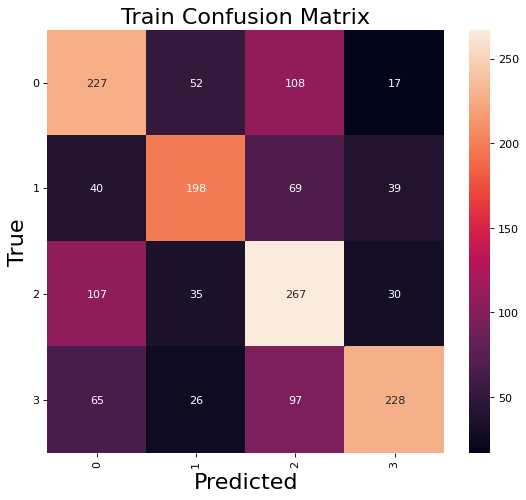

Got 920 / 1605 with accuracy 57.32
Checking accuracy on Test Set


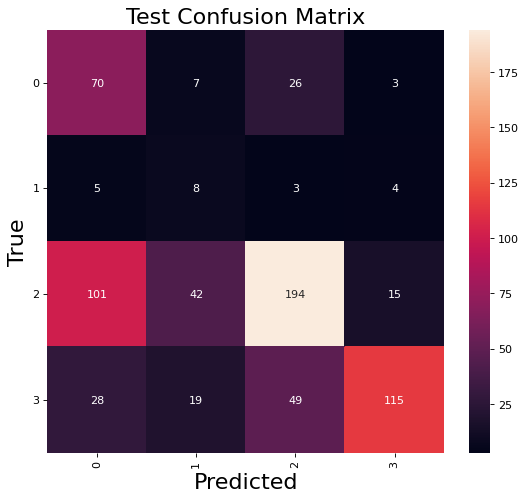

Got 387 / 689 with accuracy 56.17


In [ ]:
print("Checking accuracy on Training Set")
check_accuracy(train_loader, vgg16)

print("Checking accuracy on Test Set")
check_accuracy(test_loader, vgg16,'Test')

In [ ]:
learning_rate = 1e-4
num_epochs = 42

# Model
vgg16 = torchvision.models.vgg16(pretrained=False)

#change fc layer output dimension 
num_ftrs = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_ftrs, num_classes)

vgg16.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=learning_rate)


In [ ]:
# Train Network
train_model(vgg16,train_loader,criterion,optimizer,learning_rate,num_epochs)

  2%|▏         | 1/42 [00:12<08:52, 12.99s/it]

 Cost at epoch 0 is 1.389174826004926


  5%|▍         | 2/42 [00:25<08:39, 12.98s/it]

 Cost at epoch 1 is 1.3845062699972415


  7%|▋         | 3/42 [00:38<08:26, 12.97s/it]

 Cost at epoch 2 is 1.3860880487105425


 10%|▉         | 4/42 [00:51<08:13, 12.98s/it]

 Cost at epoch 3 is 1.3841227316388898


 12%|█▏        | 5/42 [01:04<08:00, 12.97s/it]

 Cost at epoch 4 is 1.3857411356533276


 14%|█▍        | 6/42 [01:17<07:47, 12.97s/it]

 Cost at epoch 5 is 1.3858787732965805


 17%|█▋        | 7/42 [01:30<07:34, 12.97s/it]

 Cost at epoch 6 is 1.3844627609439926


 19%|█▉        | 8/42 [01:43<07:21, 12.97s/it]

 Cost at epoch 7 is 1.3855502114576452


 21%|██▏       | 9/42 [01:56<07:08, 12.98s/it]

 Cost at epoch 8 is 1.3852815838421093


 24%|██▍       | 10/42 [02:09<06:55, 12.98s/it]

 Cost at epoch 9 is 1.3837531758289712


 26%|██▌       | 11/42 [02:22<06:42, 12.98s/it]

 Cost at epoch 10 is 1.386932695613188


 29%|██▊       | 12/42 [02:35<06:29, 12.98s/it]

 Cost at epoch 11 is 1.3847330364526487


 31%|███       | 13/42 [02:48<06:16, 12.98s/it]

 Cost at epoch 12 is 1.3821081460690965


 33%|███▎      | 14/42 [03:01<06:03, 12.98s/it]

 Cost at epoch 13 is 1.387058643733754


 36%|███▌      | 15/42 [03:14<05:50, 12.98s/it]

 Cost at epoch 14 is 1.3856247920616


 38%|███▊      | 16/42 [03:27<05:37, 12.97s/it]

 Cost at epoch 15 is 1.3836002957587148


 40%|████      | 17/42 [03:40<05:24, 12.98s/it]

 Cost at epoch 16 is 1.3830771352730544


 43%|████▎     | 18/42 [03:53<05:11, 12.98s/it]

 Cost at epoch 17 is 1.3852105444552851


 45%|████▌     | 19/42 [04:06<04:58, 12.98s/it]

 Cost at epoch 18 is 1.386582332498887


 48%|████▊     | 20/42 [04:19<04:45, 12.98s/it]

 Cost at epoch 19 is 1.3848830928989486


 50%|█████     | 21/42 [04:32<04:32, 12.98s/it]

 Cost at epoch 20 is 1.3849036506578034


 52%|█████▏    | 22/42 [04:45<04:19, 12.98s/it]

 Cost at epoch 21 is 1.385756773107192


 55%|█████▍    | 23/42 [04:58<04:06, 12.98s/it]

 Cost at epoch 22 is 1.3822738960677503


 57%|█████▋    | 24/42 [05:11<03:53, 12.99s/it]

 Cost at epoch 23 is 1.3856610831092386


 60%|█████▉    | 25/42 [05:24<03:40, 12.99s/it]

 Cost at epoch 24 is 1.3861587959177353


 62%|██████▏   | 26/42 [05:37<03:27, 12.99s/it]

 Cost at epoch 25 is 1.3841475014593088


 64%|██████▍   | 27/42 [05:50<03:14, 12.99s/it]

 Cost at epoch 26 is 1.3849972720239676


 67%|██████▋   | 28/42 [06:03<03:01, 12.99s/it]

 Cost at epoch 27 is 1.3858654849669512


 69%|██████▉   | 29/42 [06:16<02:48, 12.99s/it]

 Cost at epoch 28 is 1.3816271412606334


 71%|███████▏  | 30/42 [06:29<02:35, 12.99s/it]

 Cost at epoch 29 is 1.3873049137639064


 74%|███████▍  | 31/42 [06:42<02:22, 12.99s/it]

 Cost at epoch 30 is 1.384473305122525


 76%|███████▌  | 32/42 [06:55<02:09, 12.99s/it]

 Cost at epoch 31 is 1.384944992906907


 79%|███████▊  | 33/42 [07:08<01:56, 12.99s/it]

 Cost at epoch 32 is 1.3821676431917678


 81%|████████  | 34/42 [07:21<01:43, 12.99s/it]

 Cost at epoch 33 is 1.3880621615578146


 83%|████████▎ | 35/42 [07:34<01:30, 12.99s/it]

 Cost at epoch 34 is 1.3828186895333083


 86%|████████▌ | 36/42 [07:47<01:17, 12.99s/it]

 Cost at epoch 35 is 1.386496338189817


 88%|████████▊ | 37/42 [08:00<01:04, 12.99s/it]

 Cost at epoch 36 is 1.3829212375715667


 90%|█████████ | 38/42 [08:13<00:51, 12.99s/it]

 Cost at epoch 37 is 1.3853467936609305


 93%|█████████▎| 39/42 [08:26<00:38, 12.99s/it]

 Cost at epoch 38 is 1.3829462668474983


 95%|█████████▌| 40/42 [08:39<00:25, 12.99s/it]

 Cost at epoch 39 is 1.3857354463315477


 98%|█████████▊| 41/42 [08:52<00:12, 12.99s/it]

 Cost at epoch 40 is 1.3808967786676742


100%|██████████| 42/42 [09:05<00:00, 12.99s/it]

 Cost at epoch 41 is 1.38482806261848


Checking accuracy on Training Set


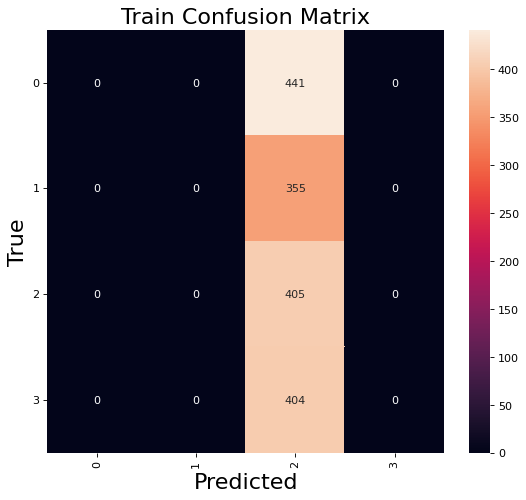

Got 405 / 1605 with accuracy 25.23
Checking accuracy on Test Set


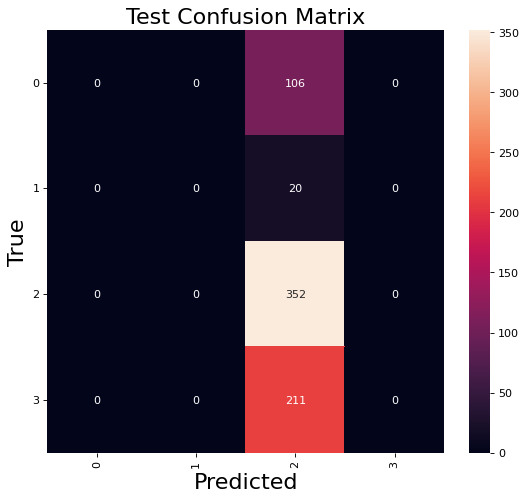

Got 352 / 689 with accuracy 51.09


In [ ]:
print("Checking accuracy on Training Set")
check_accuracy(train_loader, vgg16)

print("Checking accuracy on Test Set")
check_accuracy(test_loader, vgg16,'Test')

In [ ]:
learning_rate = 1e-4
num_epochs = 15

# Model
vgg16 = torchvision.models.vgg16(pretrained=True)

#change fc layer output dimension 
num_ftrs = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_ftrs, num_classes)

vgg16.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=learning_rate)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
# Train Network
train_model(vgg16,train_loader,criterion,optimizer,learning_rate,num_epochs)

  7%|▋         | 1/15 [00:13<03:02, 13.01s/it]

 Cost at epoch 0 is 1.2565210356431848


 13%|█▎        | 2/15 [00:26<02:49, 13.00s/it]

 Cost at epoch 1 is 0.9141970814443102


 20%|██        | 3/15 [00:39<02:36, 13.00s/it]

 Cost at epoch 2 is 0.7164736635544721


 27%|██▋       | 4/15 [00:51<02:22, 12.99s/it]

 Cost at epoch 3 is 0.5380029058923909


 33%|███▎      | 5/15 [01:04<02:09, 12.99s/it]

 Cost at epoch 4 is 0.4009544998407364


 40%|████      | 6/15 [01:17<01:56, 12.99s/it]

 Cost at epoch 5 is 0.41518690320206625


 47%|████▋     | 7/15 [01:30<01:43, 12.99s/it]

 Cost at epoch 6 is 0.33275825552204075


 53%|█████▎    | 8/15 [01:43<01:30, 12.99s/it]

 Cost at epoch 7 is 0.2986539486868709


 60%|██████    | 9/15 [01:56<01:17, 12.99s/it]

 Cost at epoch 8 is 0.2974872995241016


 67%|██████▋   | 10/15 [02:09<01:04, 12.99s/it]

 Cost at epoch 9 is 0.27439618826496837


 73%|███████▎  | 11/15 [02:22<00:51, 13.00s/it]

 Cost at epoch 10 is 0.2824490878219698


 80%|████████  | 12/15 [02:35<00:38, 12.99s/it]

 Cost at epoch 11 is 0.2103468929143513


 87%|████████▋ | 13/15 [02:48<00:25, 12.99s/it]

 Cost at epoch 12 is 0.27868321406490665


 93%|█████████▎| 14/15 [03:01<00:12, 12.99s/it]

 Cost at epoch 13 is 0.16603709392103494


100%|██████████| 15/15 [03:14<00:00, 12.99s/it]

 Cost at epoch 14 is 0.2132333331540519


Checking accuracy on Training Set


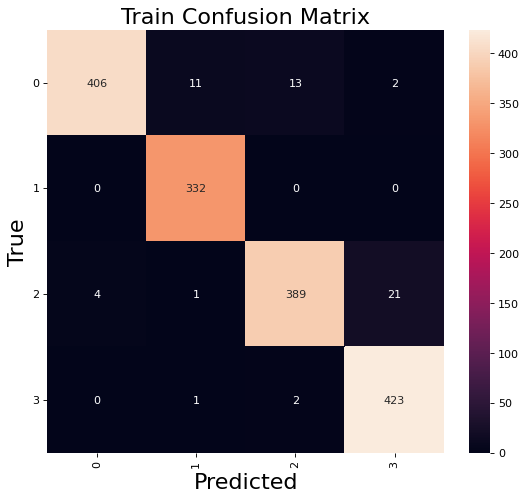

Got 1550 / 1605 with accuracy 96.57
Checking accuracy on Test Set


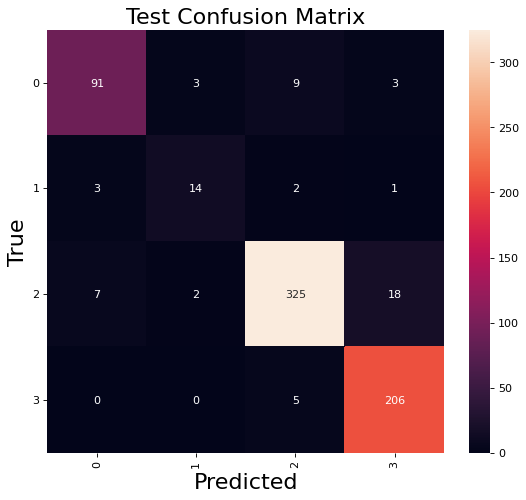

Got 636 / 689 with accuracy 92.31


In [ ]:
print("Checking accuracy on Training Set")
check_accuracy(train_loader, vgg16)

print("Checking accuracy on Test Set")
check_accuracy(test_loader, vgg16,'Test')

In [ ]:
import torch.nn.functional as F

class conv_net(nn.Module):
    def __init__(self, device='cpu'):
        """ Initialize conv_net
        Args:
            None
        Returns:
            None
        """
        super(conv_net,self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 100, kernel_size = 11, stride = 3) #[(224+2*0-11)/3 +1] = 72
        self.max_pool1 = nn.MaxPool2d(kernel_size = 3, stride = 2) #[(72+2*0-3)/2 +1]= 35
        self.conv2 = nn.Conv2d(in_channels = 100, out_channels = 512, kernel_size = 3, stride = 1) #[(35+2*0-3)/1 +1]= 33 
        self.conv3 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 2) #[(33+2*0-3)/2 +1]= 16 
        self.max_pool2 = nn.MaxPool2d(kernel_size = 3, stride = 2) #[(16+2*0-3)/2 +1]= 7
        self.conv4 = nn.Conv2d(in_channels = 512, out_channels = 256, kernel_size = 3, stride = 1) #[(7+2*0-3)/1 +1]= 5
        self.max_pool3 = nn.MaxPool2d(kernel_size = 3, stride = 1) # [(5+2*0-3)/1 +1]= 3 
        
        ### TODO: calculate number of in_features for this layer
        self.linear = nn.Linear(in_features = 256*3*3 , out_features = 4)
        self.device = device
        self.params = {}
        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.zeros_(self.conv1.bias)

        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.zeros_(self.conv2.bias)

        nn.init.xavier_uniform_(self.conv3.weight)
        nn.init.zeros_(self.conv3.bias)

        nn.init.xavier_uniform_(self.conv4.weight)
        nn.init.zeros_(self.conv4.bias)

        #nn.init.xavier_uniform_(self.conv5.weight)
        #nn.init.zeros_(self.conv5.bias)
        
        nn.init.xavier_uniform_(self.linear.weight)
        nn.init.zeros_(self.linear.bias)
        
    
    def forward(self,x):
        """ Perform forward pass
        Args:
            x (torch.tensor): tensor of images of shape  (B, C, H, W)
        Returns:
            torch.tensor: tesnor of output of shape (B, N_classes)
        """
        
        x = F.relu(self.conv1(x))
        x = self.max_pool1(x)
        x = F.relu(self.conv2(x))#,self.conv2.weight,self.conv2.bias
        x = F.relu(self.conv3(x))
        x = self.max_pool2(x)
        x = F.relu(self.conv4(x))
        #x = F.relu(self.conv5(x))
        x = self.max_pool3(x)
        x = x.reshape(x.shape[0], -1).to(device)
        x = self.linear(x)
        return x
        
model = conv_net()
print(model)

conv_net(
  (conv1): Conv2d(3, 100, kernel_size=(11, 11), stride=(3, 3))
  (max_pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(100, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2))
  (max_pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
  (max_pool3): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=2304, out_features=4, bias=True)
)


In [ ]:
# Training hyper parameters
epochs = 50
learning_rate = 0.0001

### TODO: Set target device for computations
device = torch.device("cuda" if torch.cuda.is_available() else "cuda")
print(f'device: {device}')


### TODO: Initialize conv_net
model = conv_net().to(device)
### TODO: Put model parameters on target device

### TODO: Initialize Adam optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

train_loss_tracker = []
train_accuracy_tracker = []

test_loss_tracker = []
test_accuracy_tracker = []

for epoch in range(epochs):
    train_loss,train_accuracy = Train(model,optimizer,train_loader,device)
    test_loss , test_accuracy = Test(model,test_loader,device)
    train_loss_tracker.extend(train_loss)
    train_accuracy_tracker.extend(train_accuracy)
    test_loss_tracker.append(test_loss)
    test_accuracy_tracker.append(test_accuracy)
    print(f'epoch: {epoch}')
    print('\t training loss/accuracy: {0:.2f}/{1:.2f}'.format(sum(train_loss)/len(train_loss), sum(train_accuracy)/len((train_accuracy))))
    print('\t testing loss/accuracy: {0:.2f}/{1:.2f}'.format(test_loss, test_accuracy))

device: cuda
epoch: 0
	 training loss/accuracy: 1.37/26.04
	 testing loss/accuracy: 1.37/22.69
epoch: 1
	 training loss/accuracy: 1.26/40.62
	 testing loss/accuracy: 1.15/36.25
epoch: 2
	 training loss/accuracy: 1.20/40.62
	 testing loss/accuracy: 1.21/27.31
epoch: 3
	 training loss/accuracy: 1.11/47.92
	 testing loss/accuracy: 1.12/57.65
epoch: 4
	 training loss/accuracy: 1.04/47.92
	 testing loss/accuracy: 1.14/37.97
epoch: 5
	 training loss/accuracy: 1.24/46.88
	 testing loss/accuracy: 1.12/51.35
epoch: 6
	 training loss/accuracy: 1.02/51.04
	 testing loss/accuracy: 1.03/52.00
epoch: 7
	 training loss/accuracy: 0.86/61.46
	 testing loss/accuracy: 1.06/59.22
epoch: 8
	 training loss/accuracy: 0.95/58.33
	 testing loss/accuracy: 1.04/47.70
epoch: 9
	 training loss/accuracy: 1.16/54.17
	 testing loss/accuracy: 1.11/54.38
epoch: 10
	 training loss/accuracy: 0.94/58.33
	 testing loss/accuracy: 1.00/58.39
epoch: 11
	 training loss/accuracy: 0.87/64.58
	 testing loss/accuracy: 1.06/60.49
e

In [ ]:
def Train(model,optimizer,dataloader,device):
    """ performs training on train set
    Args:
        model (my_nn instance): model to be trained
        optimizer (torch.optim instance)
        dataloader (torch.utils.data.DataLoader instance): dataloader for train set
        device (str): computation device ['cpu','cuda',...]
    Returns:
        list of floats: mini_batch loss sampled every 20 steps for visualization purposes
        list of floats: mini_batch accuracy sampled every 20 steps for visualization purposes
    """
    loss_tracker = []
    accuracy_tracker = []
    loss_fn = nn.CrossEntropyLoss()
    for i,(data,label) in enumerate(dataloader):
        ### TODO: Put data and label on target device
        data=data.to(device)
        label=label.to(device)
        ### TODO: Set gradients to zero
        optimizer.zero_grad()
        ### TODO: Pass data to the model
        scores = model(data) #CNN
        
        loss = loss_fn(scores, label).to(device) # Calculate cross entropy loss
        loss.backward()
        optimizer.step()

        if i % 20 == 0:
          with torch.no_grad():
              loss_tracker.append(loss.item())
              ### TODO: calculate accuracy of mini_batch
              _, predicted = torch.max(scores.data, 1)

              num_correct = (predicted == label).sum().item()
              #print(num_correct)
              num_samples = label.size(0)
              accuracy = num_correct/num_samples*100
              accuracy_tracker.append(accuracy)
          
    return loss_tracker, accuracy_tracker

def Test(model,dataloader,device):
    """ performs training on train set
    Args:
        model (my_nn instance): model to be trained
        dataloader (torch.utils.data.DataLoader instance)
        device (str): computation device ['cpu','cuda',...]
    Returns:
        floats: test set loss for visualization purposes
        floats: test set accuracy for visualization purposes
    """
    loss_tracker = []
    accuracy_tracker = []
    loss_fn = nn.CrossEntropyLoss()
    for i,(data,label) in enumerate(dataloader):
        ### TODO: Put data and label on target device
        data=data.to(device=device)
        label=label.to(device=device)
        
        with torch.no_grad():
            ### TODO: Pass data to the model
#######################
            #scores = model.forward(data).to(device) #Feedforward NN
            scores = model(data) #CNN

            loss = loss_fn(scores, label).to(device) # Calculate cross entropy loss
            _, predicted = torch.max(scores.data, 1)

            num_correct = (predicted == label).sum().item()
            #print(num_correct)
            num_samples = label.size(0)
            accuracy = num_correct/num_samples*100
        loss_tracker.append(loss.item())
        accuracy_tracker.append(accuracy)
        
    return sum(loss_tracker)/len(loss_tracker), sum(accuracy_tracker)/len(accuracy_tracker)
             

Checking accuracy on Training Set


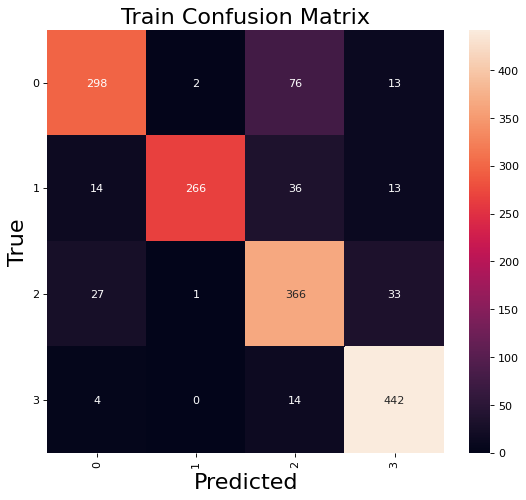

Got 1372 / 1605 with accuracy 85.48
Checking accuracy on Test Set


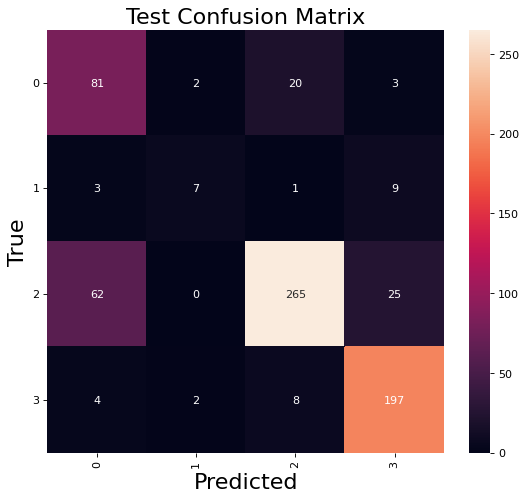

Got 550 / 689 with accuracy 79.83


In [ ]:
print("Checking accuracy on Training Set")
check_accuracy(train_loader, model)

print("Checking accuracy on Test Set")
check_accuracy(test_loader, model,'Test')